In [151]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd # type: ignore
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import scipy.stats as stats

In [152]:
def col_domain(df, col):
    return df[col].unique()


def cols_with_missing_vals(df):
    missing_vals = df.isnull().sum()
    
    print(missing_vals[missing_vals > 0])


def impute_occupation_level(row):
    if row['Field of occupation'] == 'Unoccupied' and pd.isnull(row['Occupation level']):
        return 'Unoccupied'
    elif pd.isnull(row['Occupation level']):
        return df.loc[df['Field of occupation'] == row['Field of occupation'], 'Occupation level'].mode().iloc[0] # type: ignore
    else:
        return row['Occupation level']


def handle_missing_vals(df):
    df['Occupation level'] = df.apply(impute_occupation_level, axis='columns')

    df.dropna(axis='index', subset=['Country of residence'], inplace=True)

    df['S3Q11'].fillna('Other', inplace=True)

    df['S3Q12'].fillna('No', inplace=True)


def handle_inconsistencies(df):
    df['Education level'] = df['Education level'].replace('Masters', 'Completed Undergraduate Degree')

    df['Occupation level'] = df['Occupation level'].replace('Mid level', 'Middle level')
    
    df = df[~df['S3Q8'].str.startswith('I think')]
    df['S3Q8'] = df['S3Q8'].str.strip()

    df['S3Q11'] = df['S3Q11'].str.replace('.', '')
    df['S3Q11'] = df['S3Q11'].str.strip()
    
    return df


def bin(df):
    target_col = 'Age'

    bins = [20, 30, 40, 50, 60, 70]
    labels = ['20-29', '30-39', '40-49', '50-59', '60+']
    
    df[target_col] = pd.cut(df[target_col], bins=bins, labels=labels, right=False)
    
    return df


def unwrap_mcqs(df):
    target_col = 'S3Q8'
    
    dummies = df[target_col].str.get_dummies(', ').astype(int)

    cust_col_names = {
        'An overall explanation of how the AI system works - once for the application': 'S3Q8C1',
        'An explanation for every decision made by the AI system - once per decision': 'S3Q8C2',
        'Explanation per decision if requested': 'S3Q1C3'
    }

    dummies.columns = dummies.columns.str.strip()
    dummies = dummies.rename(columns=cust_col_names)
    # display(dummies.head())

    df = pd.concat([df.drop(target_col, axis='columns'), dummies], axis='columns')


    target_col = 'S3Q11'
    
    dummies = df[target_col].str.get_dummies(', ').astype(int)

    cust_col_names = {
        'Easy to understand - Expect no technical expertise from me': 'S3Q11C1',
        'Faithful - Reflect the actual reasoning of the AI system': 'S3Q11C2',
        'Descriptive - State precisely what cause the AI system decision without leaving room for ambiguity': 'S3Q11C3',
        'Consistent - Provide similar explanations for similar/neighboring examples': 'S3Q11C4',
        'Discriminative - State Specific reasons influence the different decisions of AI system': 'S3Q11C5',
        'Interactive - Allow me to understand reasoning of the AI system in different granularities': 'S3Q11C6',
        "I'd like to see other options that I have in some scenarios (maybe percentage wise)": 'S3Q11C7',
        'I would like to have easy to understand explanations but with some technical aspects as well': 'S3Q11C8',
        'It depends on the scenario/context different scenarios require different explanation level': 'S3Q11C9',
        'Be transparent about potential biases associated with both the results and explanations': 'S3Q11C10',
        'I expect explanations to be infrequent (or rate to exponentially decay) and only generate explanations when previously provided explanations are not sufficient to explain the current scenario': 'S3Q11C11',
        'Other': 'S3Q11C12'
    }

    dummies.columns = dummies.columns.str.strip()
    dummies = dummies.rename(columns=cust_col_names)
    # display(dummies.head())

    df = pd.concat([df.drop(target_col, axis='columns'), dummies], axis='columns')

    return df


def calc_score(df):
    temp_df = pd.DataFrame()

    temp_df['Q1'] = df['S2Q1'].map({'Email': 1, 'Calculator': 0 , 'Clock':0, 'All of the above':0 , 'None of the above':0})
    temp_df['Q2'] = df['S2Q2'].map({'Yes': 1, 'No': 0 ,'I do not know':0})
    temp_df['Q3'] = df['S2Q3'].map({'No': 1, 'Yes': 0 ,'I do not know':0})
    temp_df['Q4'] = df['S2Q4'].map({'Yes': 1, 'No': 0 ,'I do not know':0})

    df['Score'] = temp_df.sum(axis='columns')

    return df

In [153]:
df = pd.read_csv("data.csv")

In [154]:
display(df.describe())
display(df.head())

print(*df.columns, sep='\n', end='\n\n')
cols_with_missing_vals(df)

,Age,S3Q7P1,S3Q7P2,S3Q7P3,S3Q7P4,S3Q7P5,S3Q10P1,S3Q10P2,S3Q10P3,S3Q10P4,S3Q10P5
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,31.495413,2.262997,2.045872,2.657492,3.226300,3.241590,2.168196,2.070336,2.574924,3.103976,3.354740
std,7.338808,1.217689,1.457277,1.210434,1.362574,1.422771,1.220667,1.302878,1.115857,1.273208,1.464142
min,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,28.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000
50%,32.000000,2.000000,1.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,4.000000
75%,33.000000,3.000000,3.000000,3.000000,4.000000,5.000000,3.000000,3.000000,3.000000,4.000000,5.000000
max,68.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


,Timestamp,Gender,Age,Education level,Field of occupation,Occupation level,Country of residence,S2Q1,S2Q2,S2Q3,S2Q4,S3Q1,S3Q2,S3Q3,S3Q4,S3Q5,S3Q6,S3Q7P1,S3Q7P2,S3Q7P3,S3Q7P4,S3Q7P5,S3Q8,S3Q9,S3Q10P1,S3Q10P2,S3Q10P3,S3Q10P4,S3Q10P5,S3Q11,S3Q12
0,3/21/2022 19:53:12,Female,31,Completed Undergraduate Degree,Architecture and Engineering,Entry level,Singapore,Email,Yes,No,Yes,Very important,I need an explanation for both decisions,(b),(b),(a),(a),1,1,1,3,1,An explanation for every decision made by the ...,An explanation explaining why AI made a certai...,2,1,3,4,5,Easy to understand - Expect no technical exper...,What happens when a person doesn't agree with ...
1,3/21/2022 20:12:56,Female,24,Completed Undergraduate Degree,Unoccupied,Unoccupied,Singapore,Email,Yes,No,Yes,Important,I need an explanation when I do not get the de...,(a),(a),(a),(a),1,3,4,5,2,An overall explanation of how the AI system wo...,An explanation explaining why AI made a certai...,2,1,3,4,5,Easy to understand - Expect no technical exper...,NaN
2,3/21/2022 20:18:00,Female,31,Completed Undergraduate Degree,Computer and Mathematical,Student,Singapore,Email,Yes,Yes,Yes,Neutral,I need an explanation for both decisions,(a),(b),(a),(a),4,5,2,3,1,An overall explanation of how the AI system wo...,An explanation explaining why AI made a certai...,2,3,1,5,4,Easy to understand - Expect no technical exper...,NaN
3,3/21/2022 20:18:37,Female,26,Completed Undergraduate Degree,Computer and Mathematical,Unoccupied,Singapore,Email,Yes,Yes,Yes,Important,I need an explanation when I do not get the de...,(b),(a),(a),(a),5,4,3,2,1,An overall explanation of how the AI system wo...,An explanation explaining why AI made a certai...,3,1,2,4,5,Easy to understand - Expect no technical exper...,NaN
4,3/21/2022 20:33:45,Male,32,Completed Undergraduate Degree,Other,Executive level,Singapore,Email,Yes,No,Yes,Very important,I need an explanation for both decisions,(b),(b),(a),(a),1,2,4,5,3,An overall explanation of how the AI system wo...,An explanation explaining why AI made a certai...,4,2,1,3,5,Easy to understand - Expect no technical exper...,NaN


Timestamp
Gender
Age
Education level
Field of occupation
Occupation level
Country of residence
S2Q1
S2Q2
S2Q3
S2Q4
S3Q1
S3Q2
S3Q3
S3Q4
S3Q5
S3Q6
S3Q7P1
S3Q7P2
S3Q7P3
S3Q7P4
S3Q7P5
S3Q8
S3Q9
S3Q10P1
S3Q10P2
S3Q10P3
S3Q10P4
S3Q10P5
S3Q11
S3Q12

Occupation level          6
Country of residence      1
S3Q11                     2
S3Q12                   289
dtype: int64


In [155]:
handle_missing_vals(df)
df = handle_inconsistencies(df)
df = bin(df)
df = unwrap_mcqs(df)
df = calc_score(df)

display(df.head())

,Timestamp,Gender,Age,Education level,Field of occupation,Occupation level,Country of residence,S2Q1,S2Q2,S2Q3,S2Q4,S3Q1,S3Q2,S3Q3,S3Q4,S3Q5,S3Q6,S3Q7P1,S3Q7P2,S3Q7P3,S3Q7P4,S3Q7P5,S3Q9,S3Q10P1,S3Q10P2,S3Q10P3,S3Q10P4,S3Q10P5,S3Q12,S3Q8C2,S3Q8C1,S3Q1C3,S3Q11C10,S3Q11C4,S3Q11C3,S3Q11C5,S3Q11C1,S3Q11C2,S3Q11C11,S3Q11C8,S3Q11C7,S3Q11C6,S3Q11C9,S3Q11C12,Score
0,3/21/2022 19:53:12,Female,30-39,Completed Undergraduate Degree,Architecture and Engineering,Entry level,Singapore,Email,Yes,No,Yes,Very important,I need an explanation for both decisions,(b),(b),(a),(a),1,1,1,3,1,An explanation explaining why AI made a certai...,2,1,3,4,5,What happens when a person doesn't agree with ...,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,4
1,3/21/2022 20:12:56,Female,20-29,Completed Undergraduate Degree,Unoccupied,Unoccupied,Singapore,Email,Yes,No,Yes,Important,I need an explanation when I do not get the de...,(a),(a),(a),(a),1,3,4,5,2,An explanation explaining why AI made a certai...,2,1,3,4,5,No,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,4
2,3/21/2022 20:18:00,Female,30-39,Completed Undergraduate Degree,Computer and Mathematical,Student,Singapore,Email,Yes,Yes,Yes,Neutral,I need an explanation for both decisions,(a),(b),(a),(a),4,5,2,3,1,An explanation explaining why AI made a certai...,2,3,1,5,4,No,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,3
3,3/21/2022 20:18:37,Female,20-29,Completed Undergraduate Degree,Computer and Mathematical,Unoccupied,Singapore,Email,Yes,Yes,Yes,Important,I need an explanation when I do not get the de...,(b),(a),(a),(a),5,4,3,2,1,An explanation explaining why AI made a certai...,3,1,2,4,5,No,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,3
4,3/21/2022 20:33:45,Male,30-39,Completed Undergraduate Degree,Other,Executive level,Singapore,Email,Yes,No,Yes,Very important,I need an explanation for both decisions,(b),(b),(a),(a),1,2,4,5,3,An explanation explaining why AI made a certai...,4,2,1,3,5,No,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,4


## Hypothesis Testing

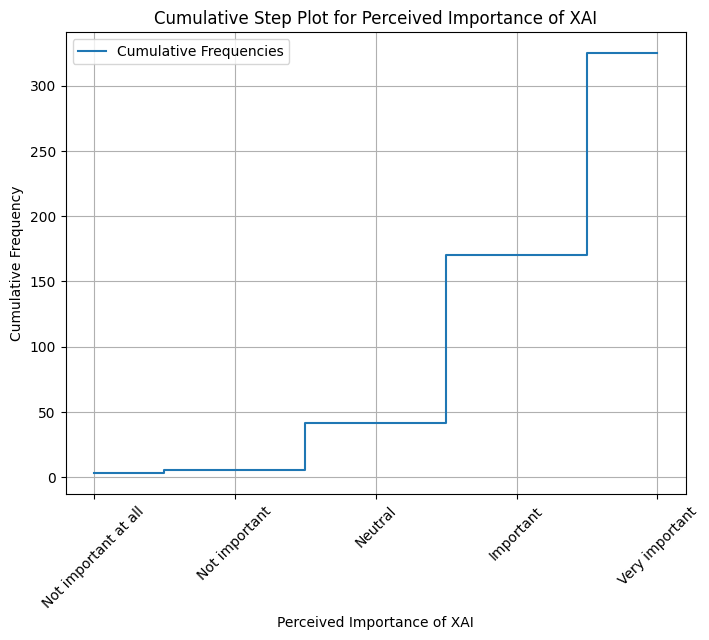

In [156]:
ordered_values = ["Not important at all", "Not important", "Neutral", "Important", "Very important"]

value_counts = df['S3Q1'].value_counts().reindex(ordered_values).cumsum()

plt.figure(figsize=(8, 6))
plt.step(ordered_values, value_counts, where='mid', label='Cumulative Frequencies')
plt.xlabel('Perceived Importance of XAI')
plt.ylabel('Cumulative Frequency')
plt.title('Cumulative Step Plot for Perceived Importance of XAI')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [157]:
def xai_importance_by(df, col):
    ordered_values = ["Not important at all", "Not important", "Neutral", "Important", "Very important"]

    plt.figure(figsize=(10, 8))

    for gender in df[col].unique():
        filtered_df = df[df[col] == gender]
        value_counts = filtered_df['S3Q1'].value_counts().reindex(ordered_values).fillna(0).cumsum()
        plt.step(ordered_values, value_counts, where='mid', label=gender)

    plt.xlabel('Perceived Importance of XAI')
    plt.ylabel('Cumulative Frequency')
    plt.title(f'Cumulative Step Plot for Perceived Importance of XAI by {col}')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title=col)
    plt.show()

    df['S3Q1'] = pd.Categorical(df['S3Q1'], categories=ordered_values, ordered=True)

    table = pd.crosstab(df['S3Q1'], df[col], normalize='columns')

    plt.figure(figsize=(10, 8))
    table.plot(kind='bar', stacked=False)
    plt.xlabel('Perceived Importance of XAI')
    plt.ylabel('Proportion')
    plt.title(f'Proportion of Perceived Importance of XAI by {col}')
    plt.xticks(rotation=45)
    plt.legend(title=col)
    plt.show()

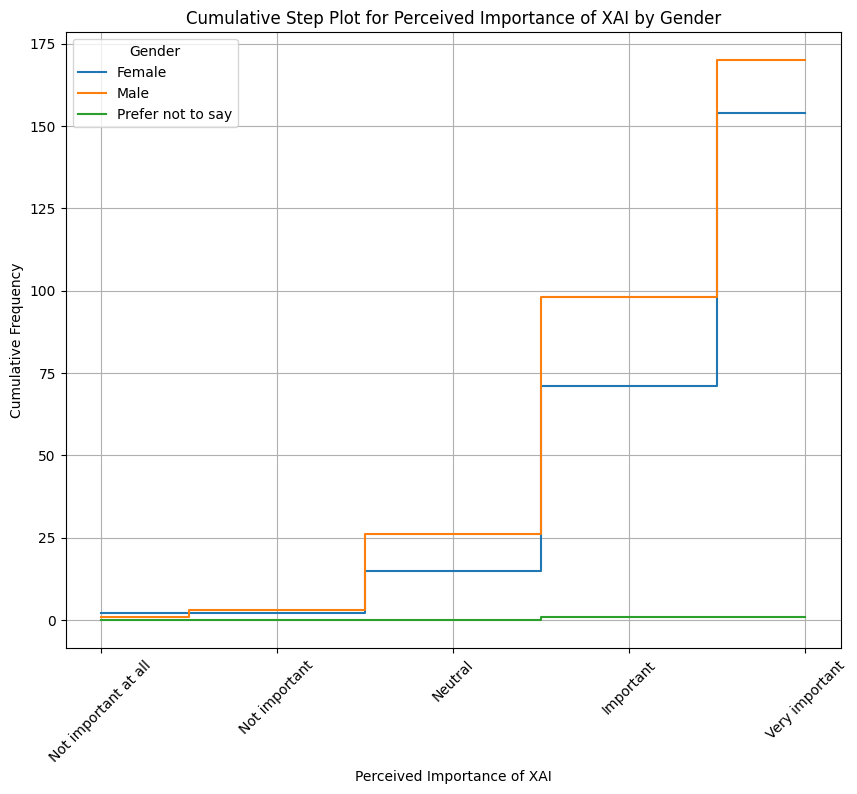

<Figure size 2000x1600 with 0 Axes>

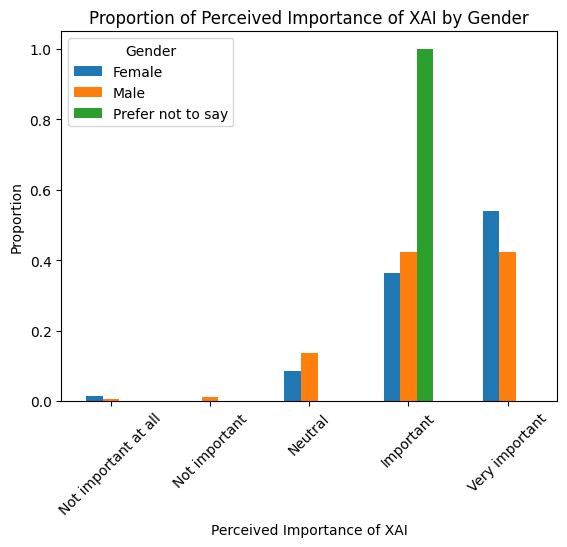

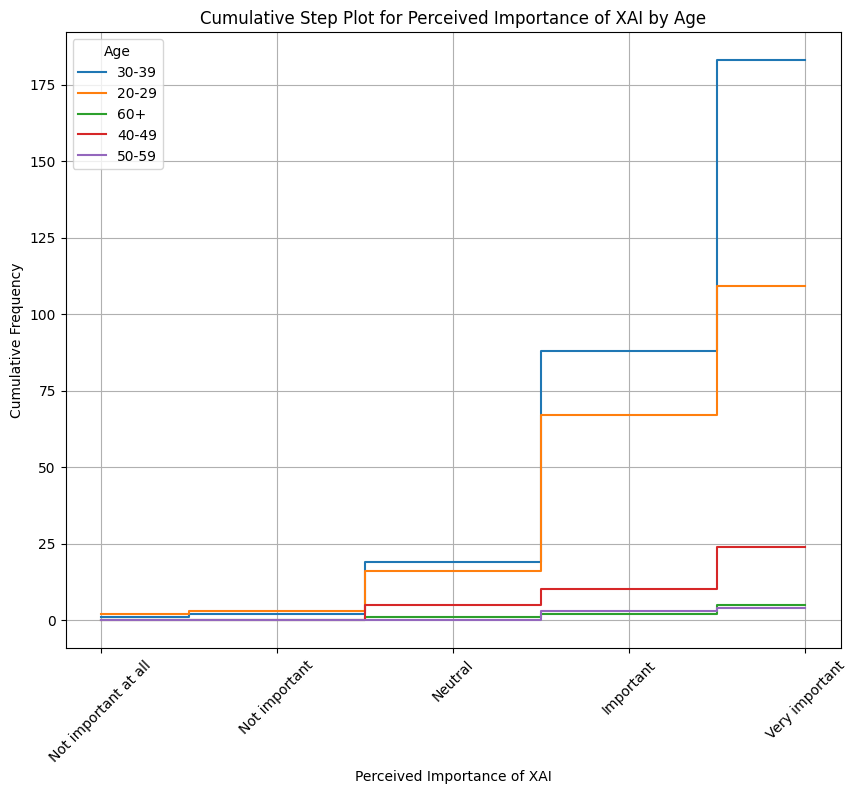

<Figure size 2000x1600 with 0 Axes>

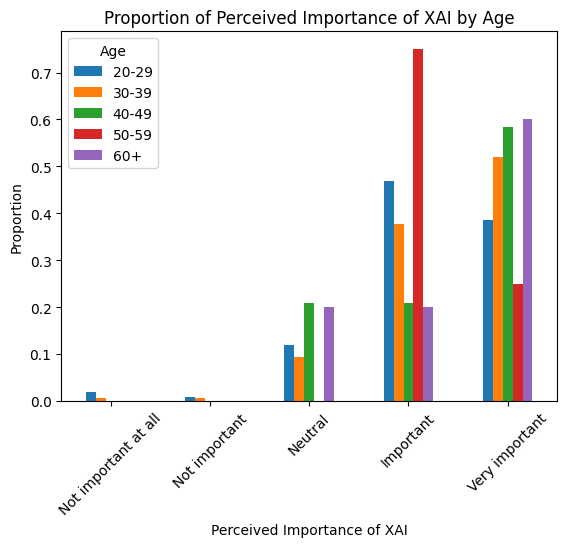

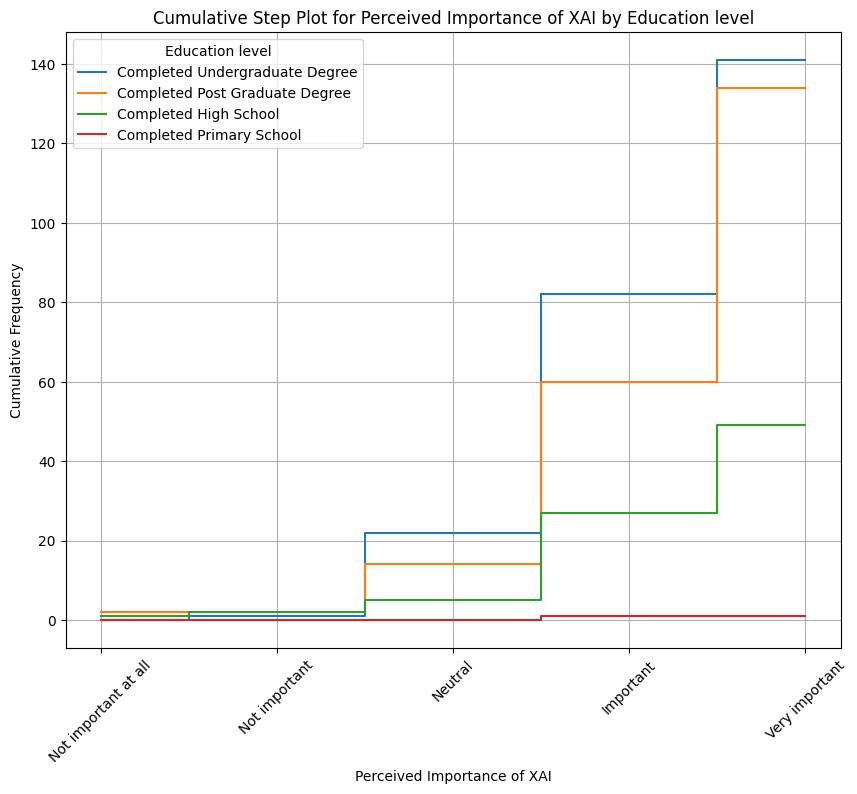

<Figure size 2000x1600 with 0 Axes>

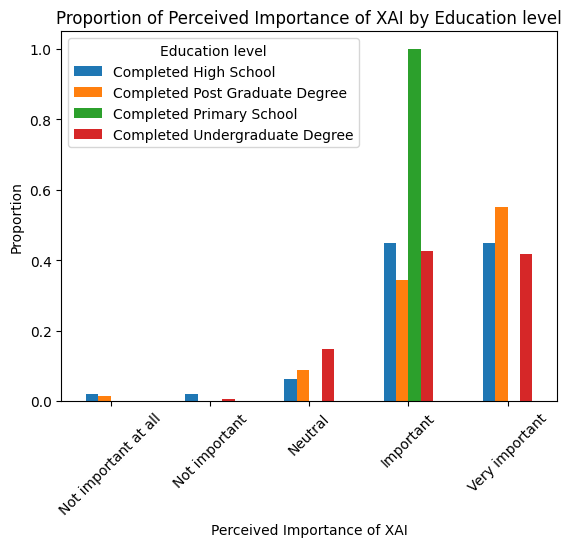

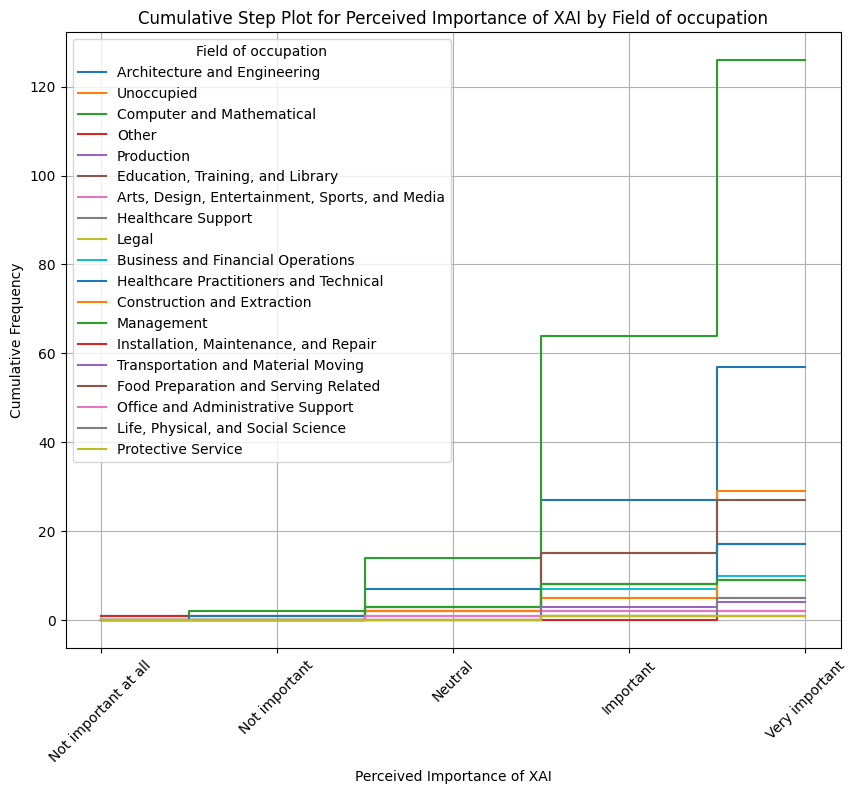

<Figure size 2000x1600 with 0 Axes>

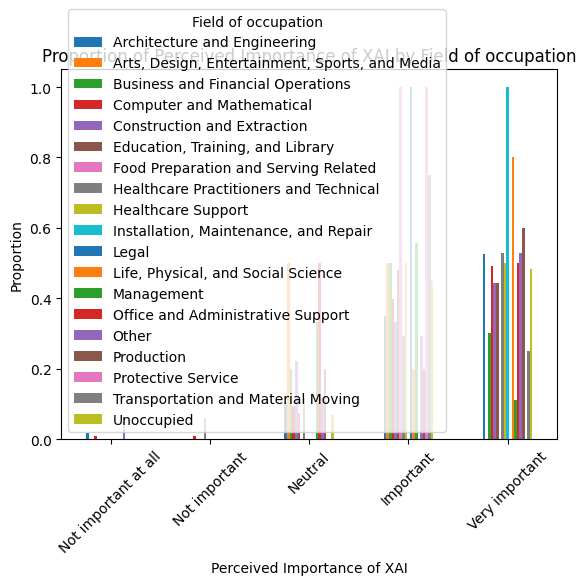

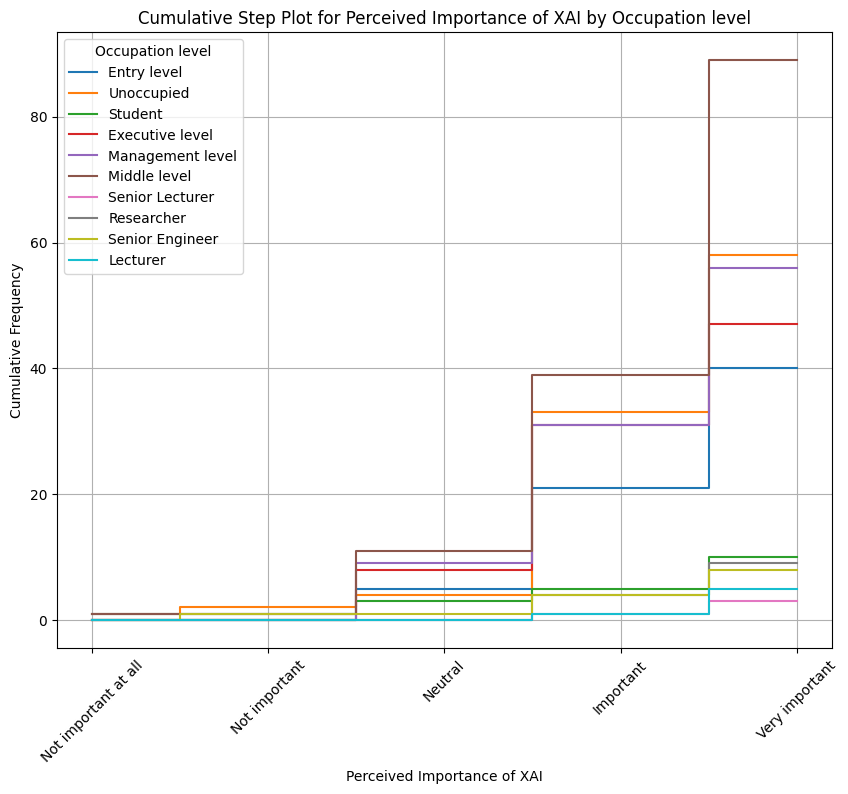

<Figure size 2000x1600 with 0 Axes>

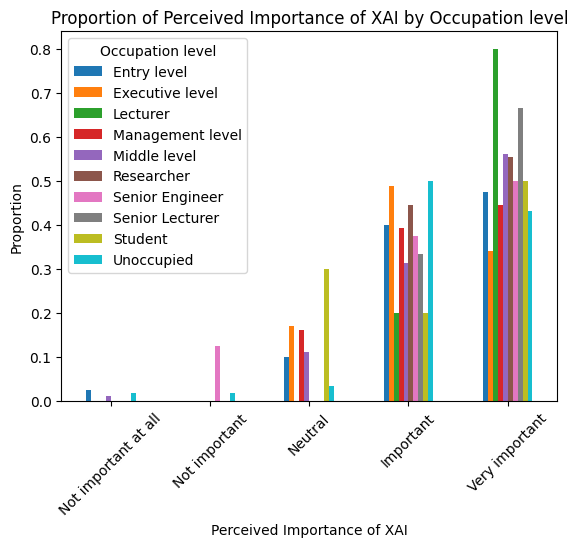

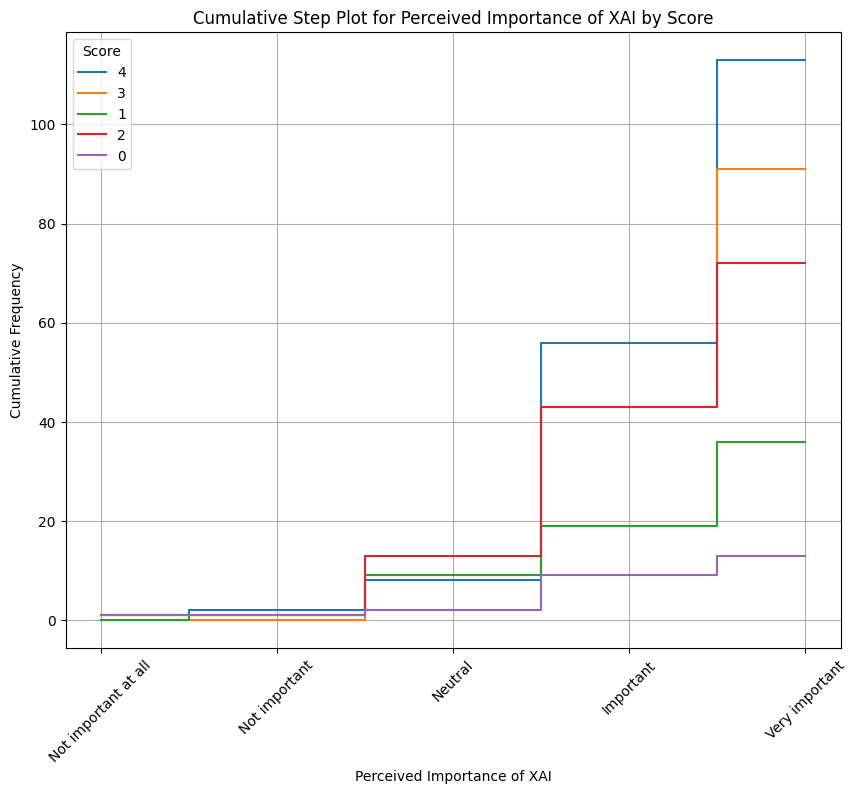

<Figure size 2000x1600 with 0 Axes>

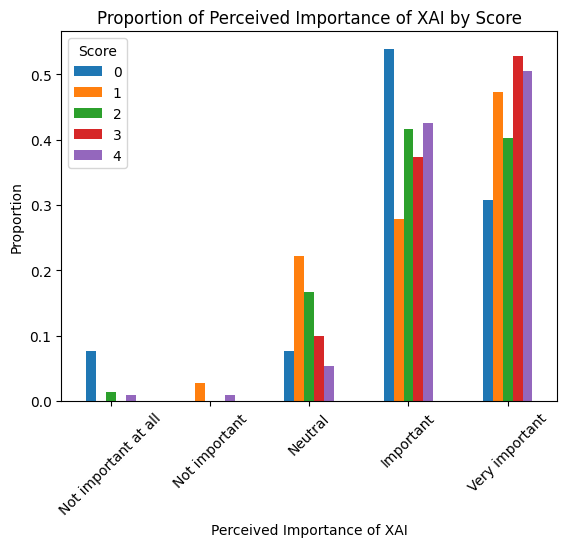

In [158]:
xai_importance_by(df, 'Gender')
xai_importance_by(df, 'Age')
xai_importance_by(df, 'Education level')
xai_importance_by(df, 'Field of occupation')
xai_importance_by(df, 'Occupation level')
xai_importance_by(df, 'Score')

In [159]:
def test_independence(df, col, alpha=0.05):
    contingency_tbl = pd.crosstab(df['S3Q1'], df[col])

    statistic, pvalue, dof, expected_freq = stats.chi2_contingency(contingency_tbl)

    print('Observed Frequencies:')
    display(contingency_tbl)
    print('Expected Frequencies:')
    display(pd.DataFrame(expected_freq, index=contingency_tbl.index, columns=contingency_tbl.columns))

    print(f'Chi-Square Statistic: {statistic}')
    print(f'P-Value: {pvalue}')
    print(f'Degrees of Freedom: {dof}')

    if pvalue < alpha:
        print(f'Reject the null hypothesis: {col} significantly impacts the perceived importance of XAI.')
    else:
        print(f'Fail to reject the null hypothesis: {col} does not significantly impact the perceived importance of XAI.', end='\n\n')

In [160]:
test_independence(df, 'Gender')
test_independence(df, 'Age')
test_independence(df, 'Education level')
test_independence(df, 'Field of occupation')
test_independence(df, 'Occupation level')
test_independence(df, 'Score')

Observed Frequencies:


Gender,Female,Male,Prefer not to say
S3Q1,,,
Not important at all,2,1,0
Not important,0,2,0
Neutral,13,23,0
Important,56,72,1
Very important,83,72,0


Expected Frequencies:


Gender,Female,Male,Prefer not to say
S3Q1,,,
Not important at all,1.421538,1.569231,0.009231
Not important,0.947692,1.046154,0.006154
Neutral,17.058462,18.830769,0.110769
Important,61.126154,67.476923,0.396923
Very important,73.446154,81.076923,0.476923


Chi-Square Statistic: 8.659329987195042
P-Value: 0.3718441566185667
Degrees of Freedom: 8
Fail to reject the null hypothesis: Gender does not significantly impact the perceived importance of XAI.

Observed Frequencies:


Age,20-29,30-39,40-49,50-59,60+
S3Q1,,,,,
Not important at all,2,1,0,0,0
Not important,1,1,0,0,0
Neutral,13,17,5,0,1
Important,51,69,5,3,1
Very important,42,95,14,1,3


Expected Frequencies:


Age,20-29,30-39,40-49,50-59,60+
S3Q1,,,,,
Not important at all,1.006154,1.689231,0.221538,0.036923,0.046154
Not important,0.670769,1.126154,0.147692,0.024615,0.030769
Neutral,12.073846,20.270769,2.658462,0.443077,0.553846
Important,43.264615,72.636923,9.526154,1.587692,1.984615
Very important,51.984615,87.276923,11.446154,1.907692,2.384615


Chi-Square Statistic: 14.632065016288538
P-Value: 0.5517334042367892
Degrees of Freedom: 16
Fail to reject the null hypothesis: Age does not significantly impact the perceived importance of XAI.

Observed Frequencies:


Education level,Completed High School,Completed Post Graduate Degree,Completed Primary School,Completed Undergraduate Degree
S3Q1,,,,
Not important at all,1,2,0,0
Not important,1,0,0,1
Neutral,3,12,0,21
Important,22,46,1,60
Very important,22,74,0,59


Expected Frequencies:


Education level,Completed High School,Completed Post Graduate Degree,Completed Primary School,Completed Undergraduate Degree
S3Q1,,,,
Not important at all,0.452308,1.236923,0.009231,1.301538
Not important,0.301538,0.824615,0.006154,0.867692
Neutral,5.427692,14.843077,0.110769,15.618462
Important,19.449231,53.187692,0.396923,55.966154
Very important,23.369231,63.907692,0.476923,67.246154


Chi-Square Statistic: 14.18403203450878
P-Value: 0.28911108175711286
Degrees of Freedom: 12
Fail to reject the null hypothesis: Education level does not significantly impact the perceived importance of XAI.

Observed Frequencies:


Field of occupation,Architecture and Engineering,"Arts, Design, Entertainment, Sports, and Media",Business and Financial Operations,Computer and Mathematical,Construction and Extraction,"Education, Training, and Library",Food Preparation and Serving Related,Healthcare Practitioners and Technical,Healthcare Support,"Installation, Maintenance, and Repair",Legal,"Life, Physical, and Social Science",Management,Office and Administrative Support,Other,Production,Protective Service,Transportation and Material Moving,Unoccupied
S3Q1,,,,,,,,,,,,,,,,,,,
Not important at all,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Not important,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Neutral,6,1,2,12,2,2,0,2,0,0,0,0,3,1,2,1,0,0,2
Important,20,1,5,50,3,13,1,5,1,0,1,1,5,0,5,1,1,3,13
Very important,30,0,3,62,4,12,0,9,1,1,0,4,1,1,9,3,0,1,14


Expected Frequencies:


Field of occupation,Architecture and Engineering,"Arts, Design, Entertainment, Sports, and Media",Business and Financial Operations,Computer and Mathematical,Construction and Extraction,"Education, Training, and Library",Food Preparation and Serving Related,Healthcare Practitioners and Technical,Healthcare Support,"Installation, Maintenance, and Repair",Legal,"Life, Physical, and Social Science",Management,Office and Administrative Support,Other,Production,Protective Service,Transportation and Material Moving,Unoccupied
S3Q1,,,,,,,,,,,,,,,,,,,
Not important at all,0.526154,0.018462,0.092308,1.163077,0.083077,0.249231,0.009231,0.156923,0.018462,0.009231,0.009231,0.046154,0.083077,0.018462,0.156923,0.046154,0.009231,0.036923,0.267692
Not important,0.350769,0.012308,0.061538,0.775385,0.055385,0.166154,0.006154,0.104615,0.012308,0.006154,0.006154,0.030769,0.055385,0.012308,0.104615,0.030769,0.006154,0.024615,0.178462
Neutral,6.313846,0.221538,1.107692,13.956923,0.996923,2.990769,0.110769,1.883077,0.221538,0.110769,0.110769,0.553846,0.996923,0.221538,1.883077,0.553846,0.110769,0.443077,3.212308
Important,22.624615,0.793846,3.969231,50.012308,3.572308,10.716923,0.396923,6.747692,0.793846,0.396923,0.396923,1.984615,3.572308,0.793846,6.747692,1.984615,0.396923,1.587692,11.510769
Very important,27.184615,0.953846,4.769231,60.092308,4.292308,12.876923,0.476923,8.107692,0.953846,0.476923,0.476923,2.384615,4.292308,0.953846,8.107692,2.384615,0.476923,1.907692,13.830769


Chi-Square Statistic: 46.87468828343493
P-Value: 0.9905112207173877
Degrees of Freedom: 72
Fail to reject the null hypothesis: Field of occupation does not significantly impact the perceived importance of XAI.

Observed Frequencies:


Occupation level,Entry level,Executive level,Lecturer,Management level,Middle level,Researcher,Senior Engineer,Senior Lecturer,Student,Unoccupied
S3Q1,,,,,,,,,,
Not important at all,1,0,0,0,1,0,0,0,0,1
Not important,0,0,0,0,0,0,1,0,0,1
Neutral,4,8,0,9,10,0,0,0,3,2
Important,16,23,1,22,28,4,3,1,2,29
Very important,19,16,4,25,50,5,4,2,5,25


Expected Frequencies:


Occupation level,Entry level,Executive level,Lecturer,Management level,Middle level,Researcher,Senior Engineer,Senior Lecturer,Student,Unoccupied
S3Q1,,,,,,,,,,
Not important at all,0.369231,0.433846,0.046154,0.516923,0.821538,0.083077,0.073846,0.027692,0.092308,0.535385
Not important,0.246154,0.289231,0.030769,0.344615,0.547692,0.055385,0.049231,0.018462,0.061538,0.356923
Neutral,4.430769,5.206154,0.553846,6.203077,9.858462,0.996923,0.886154,0.332308,1.107692,6.424615
Important,15.876923,18.655385,1.984615,22.227692,35.326154,3.572308,3.175385,1.190769,3.969231,23.021538
Very important,19.076923,22.415385,2.384615,26.707692,42.446154,4.292308,3.815385,1.430769,4.769231,27.661538


Chi-Square Statistic: 46.408528079051024
P-Value: 0.1146777004287024
Degrees of Freedom: 36
Fail to reject the null hypothesis: Occupation level does not significantly impact the perceived importance of XAI.

Observed Frequencies:


Score,0,1,2,3,4
S3Q1,,,,,
Not important at all,1,0,1,0,1
Not important,0,1,0,0,1
Neutral,1,8,12,9,6
Important,7,10,30,34,48
Very important,4,17,29,48,57


Expected Frequencies:


Score,0,1,2,3,4
S3Q1,,,,,
Not important at all,0.12,0.332308,0.664615,0.84,1.043077
Not important,0.08,0.221538,0.443077,0.56,0.695385
Neutral,1.44,3.987692,7.975385,10.08,12.516923
Important,5.16,14.289231,28.578462,36.12,44.852308
Very important,6.20,17.169231,34.338462,43.40,53.892308


Chi-Square Statistic: 26.098508132148456
P-Value: 0.05265783196548123
Degrees of Freedom: 16
Fail to reject the null hypothesis: Score does not significantly impact the perceived importance of XAI.



In [161]:
col_domain(df, 'Occupation level')

array(['Entry level', 'Unoccupied', 'Student', 'Executive level',
       'Management level', 'Middle level', 'Senior Lecturer',
       'Researcher', 'Senior Engineer', 'Lecturer'], dtype=object)